# Gesture Recognition Using CNN and Transfer Learning

### Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

In [1]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
import os
#from scipy.misc import imread, imresize
import datetime
import os
import zipfile
from imageio import imread
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')

In [6]:
pip list

Package                            Version            
---------------------------------- -------------------
absl-py                            0.10.0             
aio-pika                           6.7.1              
aiofiles                           0.6.0              
aiohttp                            3.7.3              
aiormq                             3.3.1              
alabaster                          0.7.12             
alembic                            1.4.3              
anaconda-client                    1.7.2              
anaconda-navigator                 1.9.12             
anaconda-project                   0.8.3              
APScheduler                        3.6.3              
argh                               0.26.2             
asn1crypto                         1.3.0              
astroid                            2.3.3              
astropy                            4.0                
astunparse                         1.6.3              
async-gene

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [4]:
from google.colab import drive

drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
data = pd.read_csv("/content/drive/MyDrive/Gesture_Recognition/Project_data/train.csv")

We will start with a batch size of 30

In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Gesture_Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Gesture_Recognition/Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

We will fix the image size to be 120X120 pixels and consider only 6 frames for every video. 

Let's create a generator object using the above definition

In [ ]:
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [4,9,14,19,24,29] #create a list of image numbers you want to use for a particular video
    x = len(img_idx) # number of frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(120,120))
                    temp = temp/255 #Normalize data

                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(120,120))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#                 print('2')
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Gesture_Recognition/Project_data/train'
val_path = '/content/drive/MyDrive/Gesture_Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Importing all the libraries needed for running deep learning models

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

## Model 1: Basic Conv3d

In [ ]:
model = Sequential()

model.add(Conv3D(32, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(6, 120, 120, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))


#Flatten Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 6, 120, 120, 32)   2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 120, 120, 32)   128       
_________________________________________________________________
activation (Activation)      (None, 6, 120, 120, 32)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 3, 60, 60, 32)     0         
_________________________________________________________________
flatten (Flatten)            (None, 345600)            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              345601000 
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 494.1196 - categorical_accuracy: 0.2136 Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 1111s 50s/step - loss: 490.5188 - categorical_accuracy: 0.2152 - val_loss: 113.0164 - val_categorical_accuracy: 0.2000
Epoch 2/10
23/23 [==============================] - 188s 8s/step - loss: 131.1033 - categorical_accuracy: 0.4580 - val_loss: 79.1698 - val_categorical_accuracy: 0.1250
Epoch 3/10
23/23 [==============================] - 186s 8s/step - loss: 115.9434 - categorical_accuracy: 0.3438 - val_loss: 80.8378 - val_categorical_accuracy: 0.2250
Epoch 4/10
23/23 [==============================] - 182s 8s/step - loss: 71.4467 - categorical_accuracy: 0.3201 - val_loss: 28.9015 - val_categorical_accuracy: 0.2750
Epoch 5/10
23/23 [===

## Model 2: Conv 3D with More Layers

In [ ]:
model = Sequential()

model.add(Conv3D(32, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(6, 120, 120, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(256, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(1,2,2)))


#Flatten Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 6, 120, 120, 32)   2624      
_________________________________________________________________
batch_normalization_22 (Batc (None, 6, 120, 120, 32)   128       
_________________________________________________________________
activation_22 (Activation)   (None, 6, 120, 120, 32)   0         
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 3, 60, 60, 32)     0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 3, 60, 60, 64)     55360     
_________________________________________________________________
batch_normalization_23 (Batc (None, 3, 60, 60, 64)     256       
_________________________________________________________________
activation_23 (Activation)   (None, 3, 60, 60, 64)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 10.6365 - categorical_accuracy: 0.2411 Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 508s 22s/step - loss: 10.5279 - categorical_accuracy: 0.2431 - val_loss: 4.2423 - val_categorical_accuracy: 0.2400
Epoch 2/10
23/23 [==============================] - 65s 3s/step - loss: 4.4698 - categorical_accuracy: 0.2776 - val_loss: 2.1074 - val_categorical_accuracy: 0.2250
Epoch 3/10
23/23 [==============================] - 64s 3s/step - loss: 2.5314 - categorical_accuracy: 0.3551 - val_loss: 1.4831 - val_categorical_accuracy: 0.3000
Epoch 4/10
23/23 [==============================] - 64s 3s/step - loss: 1.9275 - categorical_accuracy: 0.3151 - val_loss: 1.8485 - val_categorical_accuracy: 0.1000
Epoch 5/10
23/23 [===================

## Model 3: Conv3D with more Layers and reducing filter size to (2,2,2)

In [ ]:
model = Sequential()

model.add(Conv3D(32, #number of filters 
                 kernel_size=(2,2,2), 
                 input_shape=(6, 120, 120, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, #Number of filters, 
                 kernel_size=(2,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, #Number of filters, 
                 kernel_size=(2,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(256, #Number of filters, 
                 kernel_size=(2,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(1,2,2)))


#Flatten Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_26 (Conv3D)           (None, 6, 120, 120, 32)   800       
_________________________________________________________________
batch_normalization_26 (Batc (None, 6, 120, 120, 32)   128       
_________________________________________________________________
activation_26 (Activation)   (None, 6, 120, 120, 32)   0         
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 3, 60, 60, 32)     0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 3, 60, 60, 64)     16448     
_________________________________________________________________
batch_normalization_27 (Batc (None, 3, 60, 60, 64)     256       
_________________________________________________________________
activation_27 (Activation)   (None, 3, 60, 60, 64)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 13.2870 - categorical_accuracy: 0.2803 Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 410s 18s/step - loss: 13.1088 - categorical_accuracy: 0.2817 - val_loss: 1.4664 - val_categorical_accuracy: 0.3400
Epoch 2/10
23/23 [==============================] - 56s 2s/step - loss: 2.1473 - categorical_accuracy: 0.3734 - val_loss: 2.0245 - val_categorical_accuracy: 0.2250
Epoch 3/10
23/23 [==============================] - 54s 2s/step - loss: 1.7848 - categorical_accuracy: 0.2520 - val_loss: 2.5169 - val_categorical_accuracy: 0.1000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
23/23 [==============================] - 54s 2s/step - loss: 1.2664 - categorical_accuracy: 0.4992 - val_loss

## Model 4: Conv2D + LSTM

In [ ]:
Input_shape_1 = (6, 120, 120, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=False, dropout=0.25)) 
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_29 (TimeDis (None, 6, 120, 120, 16)   448       
_________________________________________________________________
time_distributed_30 (TimeDis (None, 6, 120, 120, 16)   64        
_________________________________________________________________
time_distributed_31 (TimeDis (None, 6, 60, 60, 16)     0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 6, 60, 60, 32)     4640      
_________________________________________________________________
time_distributed_33 (TimeDis (None, 6, 60, 60, 32)     128       
_________________________________________________________________
time_distributed_34 (TimeDis (None, 6, 30, 30, 32)     0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 6, 30, 30, 64)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.5645 - categorical_accuracy: 0.3294 Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 1239s 56s/step - loss: 1.5582 - categorical_accuracy: 0.3319 - val_loss: 1.7077 - val_categorical_accuracy: 0.2200
Epoch 2/10
23/23 [==============================] - 30s 1s/step - loss: 1.3153 - categorical_accuracy: 0.5669 - val_loss: 2.4171 - val_categorical_accuracy: 0.2000
Epoch 3/10
23/23 [==============================] - 28s 1s/step - loss: 1.5014 - categorical_accuracy: 0.3374 - val_loss: 2.7768 - val_categorical_accuracy: 0.1500

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
23/23 [==============================] - 20s 895ms/step - loss: 1.1504 - categorical_accuracy: 0.6497 - val_lo

## Model 5: Conv2D + GRU

In [ ]:
Input_shape_1 = (6, 120, 120, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False, dropout=0.25)) 
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_42 (TimeDis (None, 6, 120, 120, 16)   448       
_________________________________________________________________
time_distributed_43 (TimeDis (None, 6, 120, 120, 16)   64        
_________________________________________________________________
time_distributed_44 (TimeDis (None, 6, 60, 60, 16)     0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 6, 60, 60, 32)     4640      
_________________________________________________________________
time_distributed_46 (TimeDis (None, 6, 60, 60, 32)     128       
_________________________________________________________________
time_distributed_47 (TimeDis (None, 6, 30, 30, 32)     0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 6, 30, 30, 64)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.8274 - categorical_accuracy: 0.3176Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 137s 6s/step - loss: 1.8145 - categorical_accuracy: 0.3204 - val_loss: 2.0428 - val_categorical_accuracy: 0.1600
Epoch 2/10
23/23 [==============================] - 20s 885ms/step - loss: 1.1761 - categorical_accuracy: 0.4371 - val_loss: 2.7372 - val_categorical_accuracy: 0.1250
Epoch 3/10
23/23 [==============================] - 20s 886ms/step - loss: 1.1068 - categorical_accuracy: 0.5511 - val_loss: 2.3329 - val_categorical_accuracy: 0.1750

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
23/23 [==============================] - 20s 867ms/step - loss: 1.3505 - categorical_accuracy: 0.4351 - val

## Model 6: Transfer Learning + LSTM

In [ ]:
#TL pecific modules
#from keras.applications.vgg16 import VGG16
from keras.applications import mobilenet

#base_model=VGG16(include_top=False, weights='imagenet', pooling='avg')
base_model=mobilenet.MobileNet(weights='imagenet', include_top=False)

model=Sequential() ##   teplate where i can add my base model and add my dense r FC layes
model.add(TimeDistributed(base_model,input_shape=(6,120,120,3))) #3 base model which comes from vgg16
for layer in model.layers:
    layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=False, dropout=0.25))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_59 (TimeDis (None, 6, 3, 3, 1024)     3228864   
_________________________________________________________________
time_distributed_60 (TimeDis (None, 6, 3, 3, 1024)     4096      
_________________________________________________________________
time_distributed_61 (TimeDis (None, 6, 1, 1, 1024)     0         
_________________________________________________________________
time_distributed_62 (TimeDis (None, 6, 1024)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.6324 - categorical_accuracy: 0.2275Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 104s 4s/step - loss: 1.6303 - categorical_accuracy: 0.2298 - val_loss: 1.4588 - val_categorical_accuracy: 0.4000
Epoch 2/10
23/23 [==============================] - 15s 676ms/step - loss: 1.3554 - categorical_accuracy: 0.4508 - val_loss: 1.4679 - val_categorical_accuracy: 0.3750
Epoch 3/10
23/23 [==============================] - 17s 748ms/step - loss: 1.4512 - categorical_accuracy: 0.4490 - val_loss: 1.1151 - val_categorical_accuracy: 0.5750
Epoch 4/10
23/23 [==============================] - 16s 716ms/step - loss: 1.1846 - categorical_accuracy: 0.4962 - val_loss: 1.2155 - val_categorical_accuracy: 0.4500
Epoch 5/10
23/23 [==============

## Rerunning Models 1 through 6 using a larger image sample (15 images/frames per video) and 20 epochs

In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Gesture_Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Gesture_Recognition/Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [ ]:
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [5, 8, 11, 14, 18, 20, 23, 25, 27, 29] #create a list of image numbers you want to use for a particular video
    x = len(img_idx) # number of frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(120,120))
                    temp = temp/255 #Normalize data

                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(120,120))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#                 print('2')
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Gesture_Recognition/Project_data/train'
val_path = '/content/drive/MyDrive/Gesture_Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

## Model 7: Conv3d with more layers (rerun of model 2 with more frames per video and more epoch)

In [ ]:
model = Sequential()

model.add(Conv3D(32, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(10, 120, 120, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(256, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(1,2,2)))


#Flatten Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 120, 120, 32)  128       
_________________________________________________________________
activation (Activation)      (None, 10, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 60, 60, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 60, 60, 64)     55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 60, 60, 64)     256       
_________________________________________________________________
activation_1 (Activation)    (None, 5, 60, 60, 64)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 1682s 25s/step - loss: 19.2394 - categorical_accuracy: 0.2730 - val_loss: 3.1158 - val_categorical_accuracy: 0.1600
Epoch 2/20
67/67 [==============================] - 315s 5s/step - loss: 3.0395 - categorical_accuracy: 0.2996 - val_loss: 1.8529 - val_categorical_accuracy: 0.2000
Epoch 3/20
67/67 [==============================] - 316s 5s/step - loss: 2.8949 - categorical_accuracy: 0.2204 - val_loss: 1.6893 - val_categorical_accuracy: 0.2300
Epoch 4/20
67/67 [==============================] - 323s 5s/step - loss: 1.6693 - categorical_accuracy: 0.2237 - val_loss: 3.1958 - val_categorical_accuracy: 0.1400
Epoch 5/20
67/67 [==============================] - 318s 5s/step - loss: 1.6385 - categorical_accuracy: 0.2674 - val_loss: 1.5517 - val_categorical_accuracy: 0.2600
Epoch 6/20
67/67 [==============================] - 321s 5s/step - loss: 1.51

## Model 8: Conv3d with reduced filter size (rerun of model 3 with more frames per video and more epoch)

In [ ]:
model = Sequential()

model.add(Conv3D(32, #number of filters 
                 kernel_size=(2,2,2), 
                 input_shape=(10, 120, 120, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, #Number of filters, 
                 kernel_size=(2,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, #Number of filters, 
                 kernel_size=(2,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(256, #Number of filters, 
                 kernel_size=(2,2,2), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(1,2,2)))


#Flatten Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 10, 120, 120, 32)  800       
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 120, 120, 32)  128       
_________________________________________________________________
activation_4 (Activation)    (None, 10, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 5, 60, 60, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 5, 60, 60, 64)     16448     
_________________________________________________________________
batch_normalization_5 (Batch (None, 5, 60, 60, 64)     256       
_________________________________________________________________
activation_5 (Activation)    (None, 5, 60, 60, 64)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 722s 11s/step - loss: 19.8699 - categorical_accuracy: 0.2588 - val_loss: 2.4784 - val_categorical_accuracy: 0.2600
Epoch 2/20
67/67 [==============================] - 258s 4s/step - loss: 1.5127 - categorical_accuracy: 0.3930 - val_loss: 4.7747 - val_categorical_accuracy: 0.1400
Epoch 3/20
67/67 [==============================] - 260s 4s/step - loss: 1.5694 - categorical_accuracy: 0.3166 - val_loss: 3.0023 - val_categorical_accuracy: 0.2600

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
67/67 [==============================] - 261s 4s/step - loss: 1.2713 - categorical_accuracy: 0.4827 - val_loss: 2.3556 - val_categorical_accuracy: 0.2100
Epoch 5/20
67/67 [==============================] - 261s 4s/step - loss: 1.2451 - categorical_accuracy: 0.4646 - val_loss: 3.3653 - val_categorical_accuracy: 0.14

## Model 9: Conv2d + LSTM (rerun of model 4 with more frames per video and more epoch)

In [ ]:
Input_shape_1 = (10, 120, 120, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=False, dropout=0.25)) 
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 30, 30, 64)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 3445s 52s/step - loss: 1.5722 - categorical_accuracy: 0.3426 - val_loss: 1.8427 - val_categorical_accuracy: 0.2100
Epoch 2/20
67/67 [==============================] - 90s 1s/step - loss: 1.3187 - categorical_accuracy: 0.3959 - val_loss: 2.5336 - val_categorical_accuracy: 0.2000
Epoch 3/20
67/67 [==============================] - 96s 1s/step - loss: 1.3009 - categorical_accuracy: 0.4160 - val_loss: 1.5646 - val_categorical_accuracy: 0.3000
Epoch 4/20
67/67 [==============================] - 87s 1s/step - loss: 1.5373 - categorical_accuracy: 0.3592 - val_loss: 1.5312 - val_categorical_accuracy: 0.2800
Epoch 5/20
67/67 [==============================] - 87s 1s/step - loss: 1.4970 - categorical_accuracy: 0.3572 - val_loss: 1.4850 - val_categorical_accuracy: 0.4100
Epoch 6/20
67/67 [==============================] - 86s 1s/step - loss: 1.4142 - c

# Model 10: Conv2d + GRU (rerun of model 5 with more frames per video and more epoch)

In [ ]:
Input_shape_1 = (10, 120, 120, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False, dropout=0.25)) 
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 10, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 10, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 10, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 10, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 10, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 10, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 10, 30, 30, 64)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 259s 4s/step - loss: 1.7174 - categorical_accuracy: 0.3136 - val_loss: 2.0469 - val_categorical_accuracy: 0.2600
Epoch 2/20
67/67 [==============================] - 100s 1s/step - loss: 1.3057 - categorical_accuracy: 0.5233 - val_loss: 2.5091 - val_categorical_accuracy: 0.2000
Epoch 3/20
67/67 [==============================] - 103s 2s/step - loss: 1.6843 - categorical_accuracy: 0.3395 - val_loss: 2.4671 - val_categorical_accuracy: 0.2600

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
67/67 [==============================] - 101s 2s/step - loss: 1.4360 - categorical_accuracy: 0.3833 - val_loss: 2.3035 - val_categorical_accuracy: 0.2300
Epoch 5/20
67/67 [==============================] - 99s 1s/step - loss: 1.3224 - categorical_accuracy: 0.4161 - val_loss: 2.1783 - val_categorical_accuracy: 0.3300


# Model 11: Transfer Learning(VGG16) + LSTM (rerun of model 6 with more frames per video and more epoch)

In [ ]:
#TL pecific modules
#from keras.applications.vgg16 import VGG16
from keras.applications import mobilenet

#base_model=VGG16(include_top=False, weights='imagenet', pooling='avg')
base_model=mobilenet.MobileNet(weights='imagenet', include_top=False)

model=Sequential() ##   teplate where i can add my base model and add my dense r FC layes
model.add(TimeDistributed(base_model,input_shape=(10,120,120,3))) #3 base model which comes from vgg16
for layer in model.layers:
    layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=False, dropout=0.25))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))


17227776/17225924 [==============================] - 0s 0us/step


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_25 (TimeDis (None, 10, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_26 (TimeDis (None, 10, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 10, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 10, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 183s 3s/step - loss: 1.5936 - categorical_accuracy: 0.2326 - val_loss: 1.1947 - val_categorical_accuracy: 0.6500
Epoch 2/20
67/67 [==============================] - 67s 1s/step - loss: 1.1857 - categorical_accuracy: 0.6095 - val_loss: 1.0207 - val_categorical_accuracy: 0.6000
Epoch 3/20
67/67 [==============================] - 70s 1s/step - loss: 1.2202 - categorical_accuracy: 0.4814 - val_loss: 0.9233 - val_categorical_accuracy: 0.7100
Epoch 4/20
67/67 [==============================] - 71s 1s/step - loss: 1.1807 - categorical_accuracy: 0.5782 - val_loss: 0.9095 - val_categorical_accuracy: 0.6200
Epoch 5/20
67/67 [==============================] - 70s 1s/step - loss: 1.0796 - categorical_accuracy: 0.5451 - val_loss: 0.7825 - val_categorical_accuracy: 0.7100
Epoch 6/20
67/67 [==============================] - 70s 1s/step - loss: 0.9222 - cat

## Model 12: Conv2d + LSTM (rerun of model 9 with SGD Optimizer)

In [ ]:
Input_shape_1 = (10, 120, 120, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=False, dropout=0.25)) 
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 30, 30, 64)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - 88s 1s/step - loss: 0.7353 - categorical_accuracy: 0.7910 - val_loss: 0.9447 - val_categorical_accuracy: 0.6100
Epoch 2/20
67/67 [==============================] - 91s 1s/step - loss: 0.7261 - categorical_accuracy: 0.7662 - val_loss: 0.9535 - val_categorical_accuracy: 0.5900
Epoch 3/20
67/67 [==============================] - 89s 1s/step - loss: 0.6622 - categorical_accuracy: 0.7811 - val_loss: 0.8934 - val_categorical_accuracy: 0.6400
Epoch 4/20
67/67 [==============================] - 88s 1s/step - loss: 0.6829 - categorical_accuracy: 0.7960 - val_loss: 0.8839 - val_categorical_accuracy: 0.6200
Epoch 5/20
67/67 [==============================] - 89s 1s/step - loss: 0.7046 - categorical_accuracy: 0.7910 - val_loss: 0.9639 - val_categorical_accuracy: 0.5800
Epoch 6/20
67/67 [==============================] - 91s 1s/step - loss: 0.6650 - categorical_accuracy: 0.8010 - val_loss: 0.9418 - val_categorical_accuracy: 0.6200

Epoch 00006: Re

# Model 13: Conv2d + GRU (rerun of model 10 with SGD optimizer)

In [ ]:
Input_shape_1 = (10, 120, 120, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(64, return_sequences=False, dropout=0.25)) 
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 10, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 10, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_15 (TimeDis (None, 10, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 10, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 10, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 10, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 10, 30, 30, 64)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 230s 3s/step - loss: 1.8319 - categorical_accuracy: 0.2621 - val_loss: 1.9722 - val_categorical_accuracy: 0.2100
Epoch 2/20
67/67 [==============================] - 88s 1s/step - loss: 1.3719 - categorical_accuracy: 0.4525 - val_loss: 3.0192 - val_categorical_accuracy: 0.1800
Epoch 3/20
67/67 [==============================] - 85s 1s/step - loss: 1.3236 - categorical_accuracy: 0.4220 - val_loss: 3.5338 - val_categorical_accuracy: 0.1900

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
67/67 [==============================] - 87s 1s/step - loss: 1.1675 - categorical_accuracy: 0.5222 - val_loss: 2.8268 - val_categorical_accuracy: 0.2200
Epoch 5/20
67/67 [==============================] - 87s 1s/step - loss: 1.0660 - categorical_accuracy: 0.5482 - val_loss: 2.4339 - val_categorical_accuracy: 0.2800

Ep

# Model 14: Transfer Learning + LSTM (rerun of model 11 with SGD Optimizer)

In [ ]:
#TL pecific modules
#from keras.applications.vgg16 import VGG16
from keras.applications import mobilenet

#base_model=VGG16(include_top=False, weights='imagenet', pooling='avg')
base_model=mobilenet.MobileNet(weights='imagenet', include_top=False)

model=Sequential() ##   teplate where i can add my base model and add my dense r FC layes
model.add(TimeDistributed(base_model,input_shape=(10,120,120,3))) #3 base model which comes from vgg16
for layer in model.layers:
    layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=False, dropout=0.25))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))


17227776/17225924 [==============================] - 0s 0us/step


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_26 (TimeDis (None, 10, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_27 (TimeDis (None, 10, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_28 (TimeDis (None, 10, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 10, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 170s 2s/step - loss: 1.7276 - categorical_accuracy: 0.1847 - val_loss: 1.7010 - val_categorical_accuracy: 0.1800
Epoch 2/20
67/67 [==============================] - 70s 1s/step - loss: 1.6780 - categorical_accuracy: 0.2276 - val_loss: 1.6777 - val_categorical_accuracy: 0.2100
Epoch 3/20
67/67 [==============================] - 69s 1s/step - loss: 1.6364 - categorical_accuracy: 0.2233 - val_loss: 1.6425 - val_categorical_accuracy: 0.2000
Epoch 4/20
67/67 [==============================] - 69s 1s/step - loss: 1.7082 - categorical_accuracy: 0.1342 - val_loss: 1.6045 - val_categorical_accuracy: 0.2500
Epoch 5/20
67/67 [==============================] - 68s 1s/step - loss: 1.6607 - categorical_accuracy: 0.2351 - val_loss: 1.6340 - val_categorical_accuracy: 0.3100
Epoch 6/20
67/67 [==============================] - 71s 1s/step - loss: 1.6077 - cat

## Model 15: Conv2D + LSTM with more frames, bigger batch

In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Gesture_Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Gesture_Recognition/Project_data/val.csv').readlines())
batch_size = 20 #experiment with the batch size

In [ ]:
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0, 2, 3, 5, 7, 9, 10, 12, 14, 16, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29] #create a list of image numbers you want to use for a particular video
    x = len(img_idx) # number of frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(120,120))
                    temp = temp/255 #Normalize data

                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(120,120))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#                 print('2')
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Gesture_Recognition/Project_data/train'
val_path = '/content/drive/MyDrive/Gesture_Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

In [ ]:
Input_shape_1 = (20, 120, 120, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=False, dropout=0.25)) 
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_63 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_64 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_65 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_66 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_67 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_68 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_69 (TimeDis (None, 20, 30, 30, 64)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR] We will add the checkpoint once we finalize our model
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 3831s 116s/step - loss: 1.6013 - categorical_accuracy: 0.3136 - val_loss: 1.9185 - val_categorical_accuracy: 0.1700
Epoch 2/20
34/34 [==============================] - 119s 4s/step - loss: 1.1455 - categorical_accuracy: 0.5631 - val_loss: 1.9542 - val_categorical_accuracy: 0.1600
Epoch 3/20
34/34 [==============================] - 121s 4s/step - loss: 1.3124 - categorical_accuracy: 0.4604 - val_loss: 2.4209 - val_categorical_accuracy: 0.2200

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
34/34 [==============================] - 118s 4s/step - loss: 1.3212 - categorical_accuracy: 0.4896 - val_loss: 2.1333 - val_categorical_accuracy: 0.2900
Epoch 5/20
34/34 [==============================] - 123s 4s/step - loss: 1.2643 - categorical_accuracy: 0.3988 - val_loss: 2.4858 - val_categorical_accuracy: 0.3

## Model 16: Transfer Learning  + LSTM (rerun model 11 with more frames and bigger batch size)

In [6]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Gesture_Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Gesture_Recognition/Project_data/val.csv').readlines())
batch_size = 20 #experiment with the batch size

In [7]:
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0, 2, 3, 5, 7, 9, 10, 12, 14, 16, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29] #create a list of image numbers you want to use for a particular video
    x = len(img_idx) # number of frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(120,120))
                    temp = temp/255 #Normalize data

                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(120,120))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#                 print('2')
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Gesture_Recognition/Project_data/train'
val_path = '/content/drive/MyDrive/Gesture_Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

In [10]:
#TL pecific modules
#from keras.applications.vgg16 import VGG16
from keras.applications import mobilenet

#base_model=VGG16(include_top=False, weights='imagenet', pooling='avg')
base_model=mobilenet.MobileNet(weights='imagenet', include_top=False)

model=Sequential() ##   teplate where i can add my base model and add my dense r FC layes
model.add(TimeDistributed(base_model,input_shape=(20,120,120,3))) #3 base model which comes from vgg16
for layer in model.layers:
    layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64, return_sequences=False, dropout=0.25))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))


17227776/17225924 [==============================] - 0s 0us/step


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                278784    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1) 
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch') 
# We will add the checkpoint once we finalize our model

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR] #We will add the checkpoint once we finalize our model
#callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Gesture_Recognition/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 2676s 81s/step - loss: 1.5848 - categorical_accuracy: 0.2794 - val_loss: 1.3318 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2021-03-2821_28_08.131020/model-00001-1.53152-0.32579-1.33177-0.49000.h5
Epoch 2/20
34/34 [==============================] - 105s 3s/step - loss: 1.3587 - categorical_accuracy: 0.4499 - val_loss: 1.1931 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2021-03-2821_28_08.131020/model-00002-1.34595-0.46078-1.19314-0.55000.h5
Epoch 3/20
34/34 [==============================] - 109s 3s/step - loss: 1.3814 - categorical_accuracy: 0.3206 - val_loss: 1.0746 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2021-03-2821_28_08.131020/model-00003-1.35297-0.39216-1.07462-0.56000.h5
Epoch 4/20
34/34 [==============================] - 110s 3s/step -

## The below table provides a summary of all the models executed.

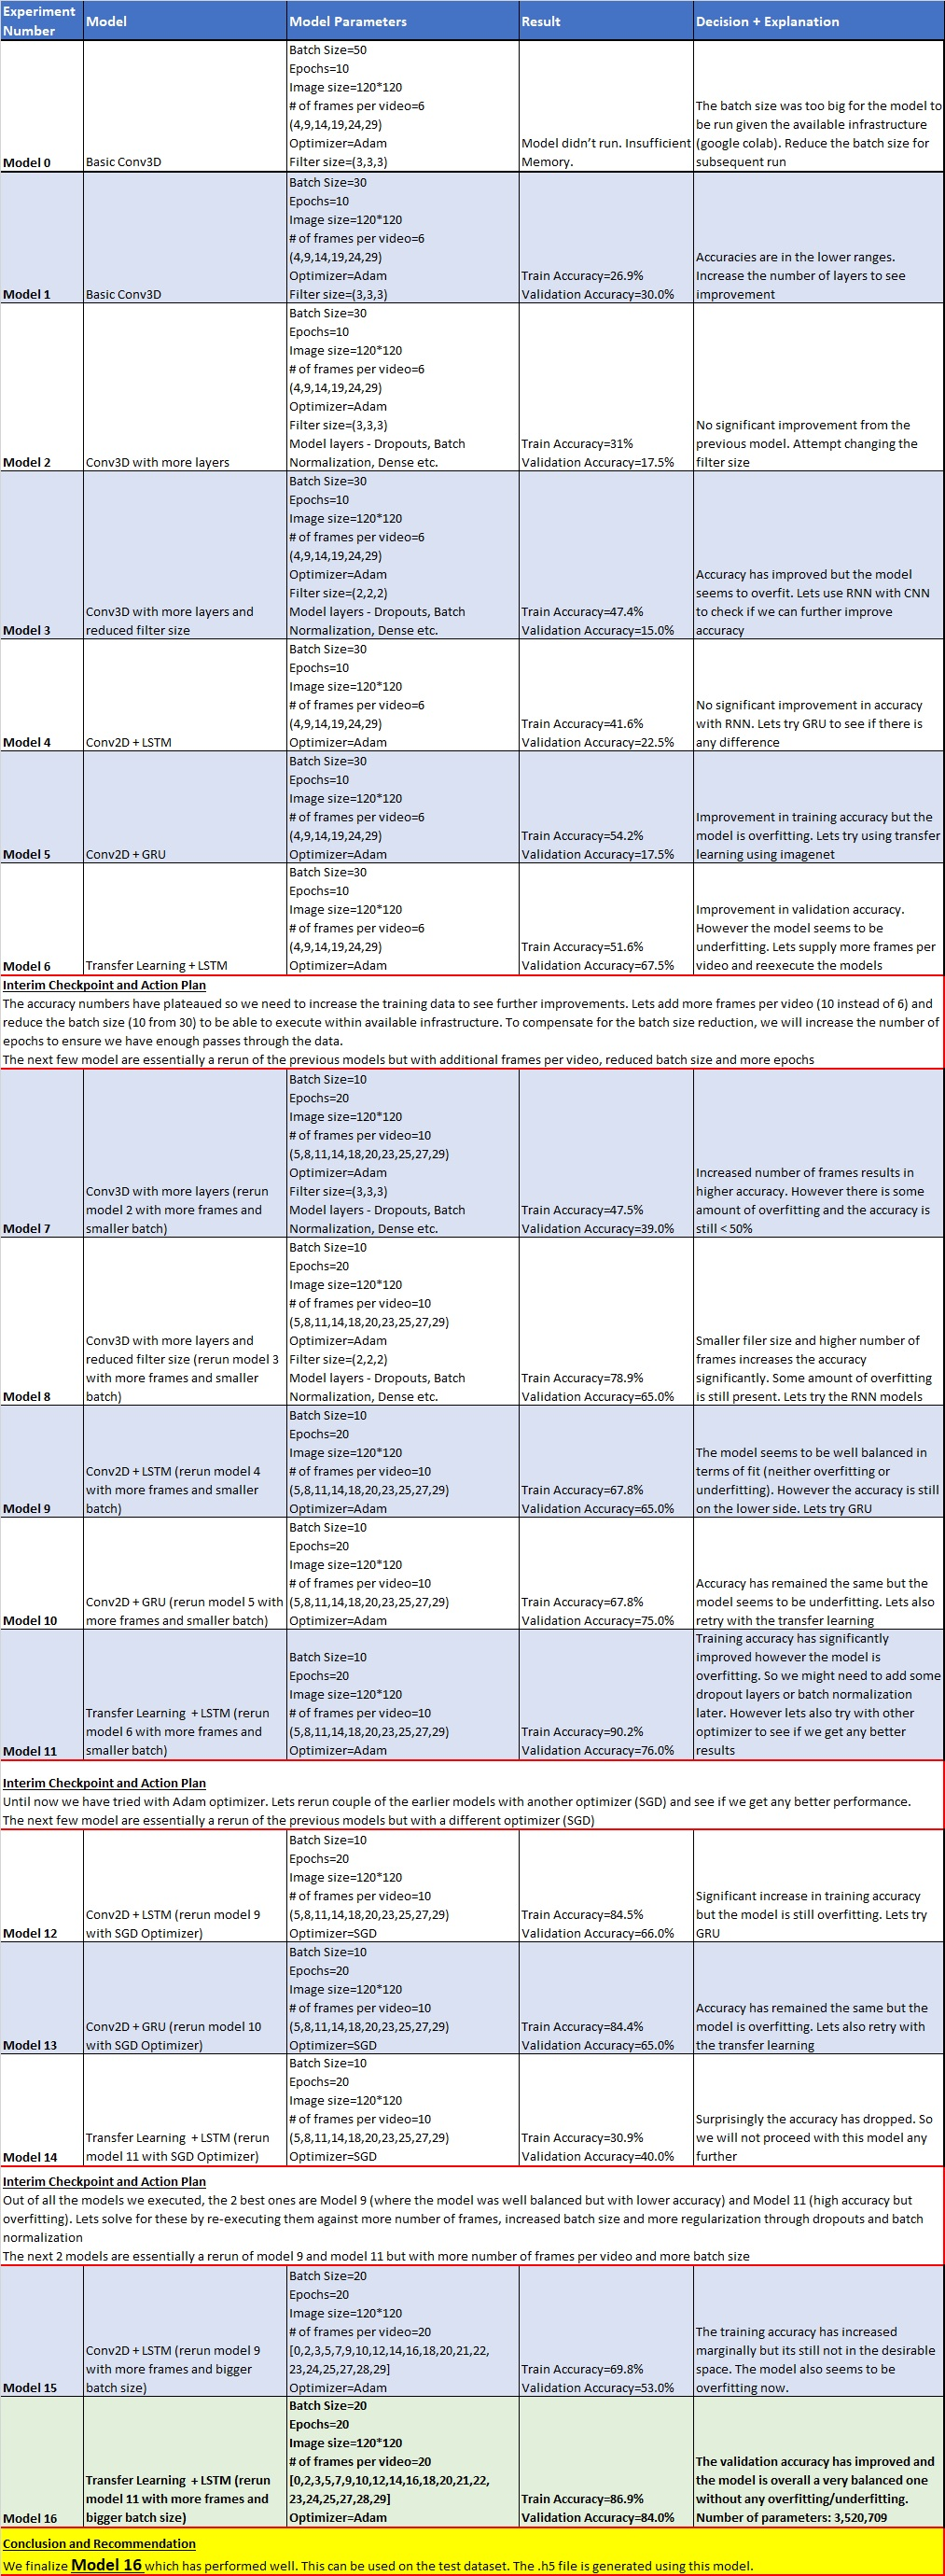

# We finalize Model 16 and recommend it to be used on the test dataset